In [113]:
#import dependencies

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pickle

In [114]:


class HealthcareFraudDetector:
    def __init__(self):
        
        #creating attributes of model instances and relevant hyperparameters for each model - xgb, lgbm, rf
        
        self.model_instances = {
            'xgb': 
                [xgb.XGBClassifier(), {
                'max_depth': [3,5,7],
                'learning_rate': [0.1, 0.01],
                'n_estimators': [100, 200, 300],
                'subsample': [0.4, 0.6, 0.8],
                'colsample_bytree': [0.4, 0.6, 0.8],
                'lambda': [0, 0.25, 0.5, 1.0]
                }], 
                    
            'lgbm': 
                [lgb.LGBMClassifier(), {
                'num_leaves': [30, 50, 100],  
                'learning_rate': [0.01, 0.1, 0.2],
                'n_estimators': [100, 200, 300]
                }],
            
                     
            'rf': 
                [RandomForestClassifier(), {
                'n_estimators': [50, 100, 200, 300],           # Number of trees in the forest
                'max_depth': [5, 10, 15, 20],               # Maximum depth of each tree
                'min_samples_split': [3,4,5],           # Minimum number of samples required to split an internal node
                'min_samples_leaf': [2,3,4]               # Minimum number of samples required to be at a leaf node
                }]
        }
        
        #number of categories to encode for each variable
        self.num_vec_params = {
            'code3_num_vec': 3,
            'code2_num_vec': 3,
            'codes_num_vec': 3,
            'phys_num_vec': 600,
            'state_num_vec': 50,
            'county_num_vec': 50
        }
        
        #universe of feature variables
        self.features = ['Admitted', 'num_claims', 'num_physicians', 'num_procedures', 'num_conditions', 'age', 'dead', 'admission_length', 'claim_duration', 'TotalClaimAmt', 'Gender',
            'ChronicCond_Cancer', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'RenalDiseaseIndicator', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
            'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'Race', 'State', 'County', 'AttendingPhysician', 'OPTotalAmount', 'IPTotalAmount'
        ]
    
    
    #load inpatient, beneficiary, and outpatient data
    def load_data(self):
        self.train_bene = pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
        self.train_inp = pd.read_csv('Train_Inpatientdata-1542865627584.csv')
        self.train_out = pd.read_csv('Train_Outpatientdata-1542865627584.csv')
        self.train_y = pd.read_csv('Train-1542865627584.csv')

        return self.train_bene, self.train_inp, self.train_out, self.train_y
    
    
    
    #data preprocessing pipeline
    def preprocess_data(self):

        #designated inpatients as admitted, and outpatients as not admitted
        self.train_inp['Admitted'] = 1
        self.train_out['Admitted'] = 0

        
        #merge beneficiary, outpatient, and inpatient data into one dataframe. 
        #merge with target variable data
        self.train_bene.head()
        train_inp_merge = pd.merge(self.train_bene, self.train_inp)
        train_out_merge = pd.merge(self.train_bene, self.train_out)
        train_df = pd.concat([train_inp_merge, train_out_merge])
        train_df = pd.merge(train_df, self.train_y)

        #Set Nan values for Deductible Amt to 0
        train_df['DeductibleAmtPaid'] = np.where(train_df['DeductibleAmtPaid'].isnull(), 0, train_df['DeductibleAmtPaid'])

        #replacing 2s with 1s - so that 0 is no and yes is 1
        chronic_cond_features = ['Gender', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
                               'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                               'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 
                               'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']

        for i in chronic_cond_features:
            train_df[i] = np.where(train_df[i] == 2,0,1)


        #Replacing 'Y' with 1 in RenalDiseaseIndicator
        train_df['RenalDiseaseIndicator'] = np.where(train_df['RenalDiseaseIndicator'] == 'Y',1,0)

        #Converting Yes/NO in target variable to boolean
        train_df['PotentialFraud'] = np.where(train_df['PotentialFraud'] == 'Yes',1, 0)

        return train_df
    
    
    
    #feature engineering pipeline
    def feature_egineering(self, train_df):

        #define available chronic condition features
        chronic_cond_features = ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
                               'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                               'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 
                               'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']

        # Create boolean for dead/alive
        train_df['dead'] = np.where(train_df['DOD'].isnull(), 0, 1)

        # Create variable for length of claim by subtracting number of days between clain end date and claim start date
        train_df['claim_duration'] = (pd.to_datetime(train_df['ClaimEndDt']) - pd.to_datetime(train_df['ClaimStartDt'])).dt.days


        # Create variable for length of admission by subtracting number of days between discharge date and admission date
        train_df['admission_length'] = (pd.to_datetime(train_df['DischargeDt']) - pd.to_datetime(train_df['AdmissionDt'])).dt.days

        #makes outpatient admission length equal to 0 days
        train_df['admission_length'] = np.where(train_df['admission_length'].isnull(), 0, train_df['admission_length'])

        #age variable - subtract DOB from claim start date and DOB, then divide by 365
        train_df['age'] = (pd.to_datetime(train_df['ClaimStartDt']) - pd.to_datetime(train_df['DOB'])).dt.days //365

        #Number of physicians variable - sum across columns for which value of physician vars is not null
        train_df['num_physicians'] = train_df[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']].notnull().sum(axis = 1)

        #Number of procedures variable - sum across Clm ProcedureCode columns for which ClmProcedureCode columns are not null
        train_df['num_procedures'] = train_df[['ClmProcedureCode_{}'.format(x) for x in range(1,7)]].notnull().sum(axis = 1)

        #Count across ClmAdmitDiagnosisCode columns for which values are not null
        ClmDiagnosisCode_vars =['ClmAdmitDiagnosisCode'] + ['ClmDiagnosisCode_{}'.format(x) for x in range(1, 11)]
        train_df['num_claims'] = train_df[ClmDiagnosisCode_vars].notnull().sum(axis = 1)


        #total claim amount
        train_df['TotalClaimAmt'] = train_df['InscClaimAmtReimbursed'] + train_df['DeductibleAmtPaid']

        #Total Inpatient Amount
        train_df['IPTotalAmount'] = train_df['IPAnnualReimbursementAmt'] + train_df['IPAnnualDeductibleAmt']

        # Total Outpatient Amount = Outpatient Annual Amount reimbursed + Outpatient Annual Deductible Amount
        train_df['OPTotalAmount'] = train_df['OPAnnualReimbursementAmt'] + train_df['OPAnnualDeductibleAmt']

        #Number of Chronic Conditions
        train_df['num_conditions'] = train_df[chronic_cond_features].notnull().sum(axis = 1)


        # Define the columns we want to encode ordinally and how many ordinal values for each column
        #(certain columns have large number of unique values)
        # we only want to encode the top n values for each column as defined by self.num_vec_params
        columns_to_encode = {
            'State': self.num_vec_params['state_num_vec'],
            'ClmDiagnosisCode_1': self.num_vec_params['codes_num_vec'],
            'ClmDiagnosisCode_2': self.num_vec_params['code2_num_vec'],
            'ClmDiagnosisCode_3': self.num_vec_params['code3_num_vec'],
            'AttendingPhysician': self.num_vec_params['phys_num_vec'],
            'County': self.num_vec_params['county_num_vec']
        }

        
        #call the ordinal_encoder method to encode the columns of interest
        train_df = self.ordinal_encoder(train_df, 'State', columns_to_encode['State'])
        train_df = self.ordinal_encoder(train_df, 'ClmDiagnosisCode_1', columns_to_encode['ClmDiagnosisCode_1'])
        train_df = self.ordinal_encoder(train_df, 'ClmDiagnosisCode_2', columns_to_encode['ClmDiagnosisCode_2'])
        train_df = self.ordinal_encoder(train_df, 'ClmDiagnosisCode_3', columns_to_encode['ClmDiagnosisCode_3'])
        train_df = self.ordinal_encoder(train_df, 'AttendingPhysician', columns_to_encode['AttendingPhysician'])
        train_df = self.ordinal_encoder(train_df, 'County', columns_to_encode['County'])


        return train_df
    
    
    #determine the most important features to reduce curse of dimensionality - reduce to 20
    def recursive_feature_elimination(self, data, model, num_features = 20):
        
        #creating an RFE instance
        rfe = RFE(estimator=model, n_features_to_select=num_features)
        
        #fitting the data to the instance
        rfe.fit(data[self.features], data['PotentialFraud'])
        
        
        selected_features = rfe.support_
        reduced_features = data[self.features].loc[:, selected_features]
        return reduced_features.columns.tolist()
    
    
    
    #ordinal encoder method
    #method is called within the feature_engineering method to ordinally encode certain columns
    def ordinal_encoder(self, df, column, top_n):

        #top values by count for the column of interest, based on the top_n value
        top_indices = df[column].value_counts()[:top_n].index
        
        #populate new column if its within the top_indices list
        df[column] = np.where(df[column].isin(top_indices), df[column], 'Other')

        #ordinally encode the new column with the fit transform method
        encoder = OrdinalEncoder()
        df[column] = encoder.fit_transform(df[[column]])

        return df
    
    
    
    #split original data into train, validation, and test sets
    def train_test_validation_split(self, train_df, split_frac=0.25):
        train, validate, test = np.split(train_df.sample(frac=1, random_state=42),
                                         [int((1-2*split_frac) * len(train_df)), int((1-split_frac) * len(train_df))])
        return train, validate, test
    
    
    #train model with fit method
    def train_model(self, train, features, model_inst):
        model_inst.fit(train[features], train['PotentialFraud'])
        return model_inst
    
    
    #Perform grid search with RandomizedSearchCV to mitigate computational time
    # returns the best_model instance and the corresponding best params
    
    def hyperparameter_tuning(self, model, param_grid, validate, num_iter=10):
        
        random_search = RandomizedSearchCV(estimator= model, param_distributions=param_grid, n_iter=num_iter, scoring='f1', cv = 3)
    
        random_search.fit(validate[self.features], validate['PotentialFraud'])

        best_params = random_search.best_params_
        best_model = random_search.best_estimator_

        return best_model, best_params
    
    
    #evaluates model by returning f1 score
    def evaluate_model(self, model, data, threshold = 0.5):
        
        #y_predictions
        y_pred = model.predict(data[self.features])

        #y_probability scores
        y_proba = model.predict_proba(data[self.features])[:, 1]
        
        #if y_probability exceeds defined threshold, set as 1
        y_pred_thresholded = np.where(y_proba >= threshold, 1, 0)

        #calculate f1 score
        f1_score_val = f1_score(data['PotentialFraud'], y_pred_thresholded)
        
        return f1_score_val
    
    
    #build a confusion matrix defined by the threshold constraint parameter
    def confusion_matrix_cust(self, model, data, threshold = 0.5):
        y_pred = model.predict(data[self.features])

        y_proba = model.predict_proba(data[self.features])[:, 1]
        #print(y_proba.mean(), y_proba.std())
        y_pred_thresholded = np.where(y_proba >= threshold, 1, 0)

        # Create the confusion matrix
        cm = confusion_matrix(data['PotentialFraud'], y_pred_thresholded)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')

        plt.show()
    
    
    #construct auc_roc curve for the results
    def auc_roc(self, model, data):

        y_probs = model.predict_proba(data[self.features])[:, 1]
        fpr, tpr, thresholds = roc_curve(data['PotentialFraud'], y_probs)

        auc_roc_score = roc_auc_score(data['PotentialFraud'], y_probs)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_roc_score:.2f}')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR) or Recall')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

In [109]:
def main():

    #fraud detector instance
    fraud_detector = HealthcareFraudDetector()

    #loading data
    train_bene, train_inp, train_out, train_y = fraud_detector.load_data()

    #preprocess data
    train_df = fraud_detector.preprocess_data()


    # Perform feature engineering
    train_df = fraud_detector.feature_engineering(train_df)


    # Split data into train, validation, and test sets
    train, validate, test = fraud_detector.train_test_validation_split(train_df)


    for model_name, model_instance in fraud_detector.model_instances.items():
        features = fraud_detector.recursive_feature_elimination(train, model_instance[0])
        trained_model = fraud_detector.train_model(train, features, model_instance[0])

        # Hyperparameter tuning
        best_model, best_params = fraud_detector.hyperparameter_tuning(model_instance[0], model_instance[1], validate)
        f1_score_val = fraud_detector.evaluate_model(best_model, test)

        # Evaluate confusion matrix and AUC-ROC
        fraud_detector.confusion_matrix_cust(best_model, test)
        fraud_detector.auc_roc(best_model, test)
        print(f"Best F1 Score for {model_name}: {f1_score_val}")        

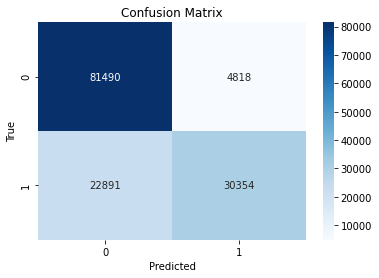

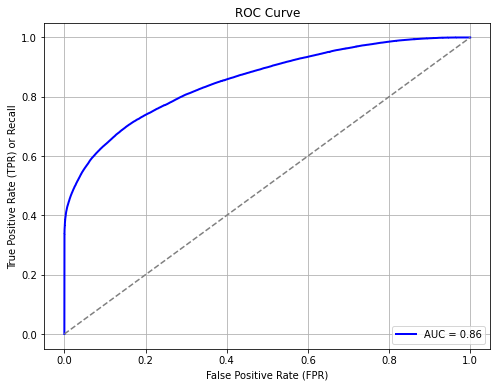

Best F1 Score for xgb: 0.6866100410554531


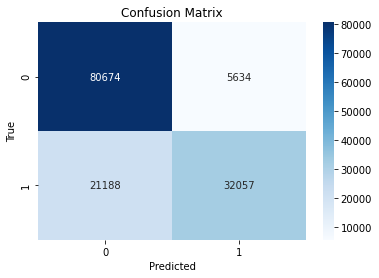

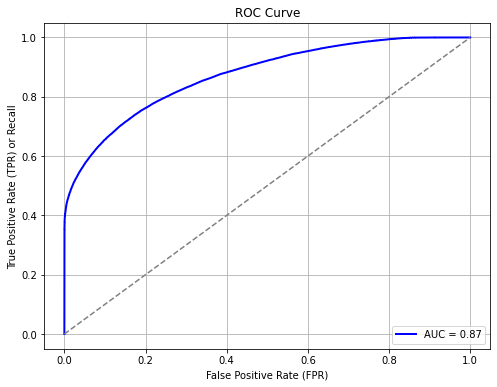

Best F1 Score for lgbm: 0.7050453065892497


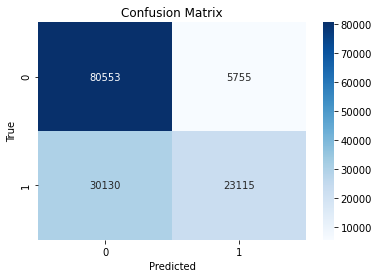

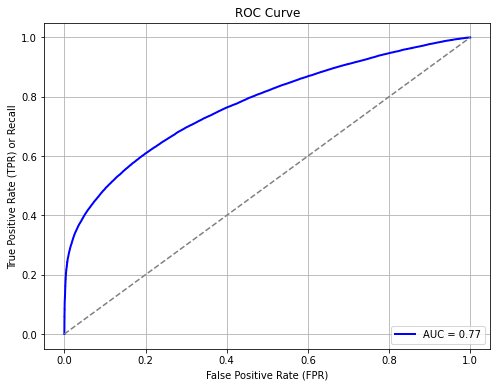

Best F1 Score for rf: 0.5629909273579736


In [110]:
if __name__ == "__main__":
    main()